<a href="https://colab.research.google.com/github/tito-par-tito/MLexam2023/blob/main/502252_MLProject_30_01_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For a better good-looking I suggest to use the .pdf file available on https://drive.google.com/file/d/1xZOrLyl5EFYfy63-SzqZWDxlns3pH4Mv/view?usp=sharing or to use https://deepnote.com/@premium-test/Elections-1-701f1006-b41b-42e1-b47d-d181800ad431 (but sadly no callout text will be shown).

Dataset used: https://drive.google.com/file/d/1kucHltK00z_ImCSRDpMLQlwXOAjb6pFx/view?usp=sharing

----

In [ ]:
import pandas as pd
import numpy as np
import itertools

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.datasets import fetch_openml

from scipy.stats import loguniform, beta, uniform

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as IMBPipeline

import missingno as msno

import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier


---

****

# Introduction

![Picture title](electoralMap.png)


The dataset is taken from https://www.kaggle.com/datasets/jwt0024/1992-us-presidential-election. The dataset was perfect and no missing data was present so I remove some elements of the features.

This dataset contains county-level demographics and whether or not Bill Clinton won each county during the 1992 U.S. presidential election. **The goal for this dataset is to successfully predict if Bill Clinton won a county using some demographic variables**.

The official results of all the counties can be seen at https://en.wikipedia.org/wiki/1992_United_States_presidential_election by clicking at each US state on the map.

> By using *1 it will convert the Boolean value to an integer. True will be converted to 1 and False will be converted to 0 ( is equivalent to using the int() function on a Boolean value).

In [ ]:
#X = pd.read_csv("election_dataset(full).csv")
X = pd.read_csv("election_dataset.csv")
X["clinton_win"] = X["clinton_win"]*1
X["vote_for_dems_before"] = X["vote_for_dems_before"]*1
y = X.pop("clinton_win")

In [ ]:
X

,county_name,median_age,mean_savings,per_capita_income,percent_in_poverty,percent_veterans,percent_female,population_density,percent_in_nursing_homes,crime_index_PC,state,vote_for_dems_before
0,Autauga,31.7,57623.0,15768.0,15.2,11.14,51.41,60.4,2.36,457.0,AL,0
1,Baldwin,35.5,84935.0,16954.0,13.6,10.13,51.34,66.5,5.40,282.0,AL,0
2,Barbour,32.8,83656.0,15532.0,25.0,9.22,53.03,28.8,7.02,47.0,AL,0
3,Blount,34.5,61249.0,14820.0,15.0,10.07,51.15,62.4,2.36,185.0,AL,0
4,Bullock,31.7,75725.0,11120.0,33.0,7.08,51.16,17.6,3.31,141.0,AL,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2408,Sheridan,NaN,87232.0,22250.0,11.6,16.59,51.13,9.5,5.07,275.0,WY,0
2409,Sublette,35.4,83020.0,NaN,7.9,NaN,48.38,1.0,8.60,432.0,WY,0
2410,Sweetwater,NaN,104346.0,19086.0,7.7,15.04,49.42,3.9,3.00,625.0,WY,0
2411,Washakie,34.6,114176.0,17608.0,11.7,14.47,50.05,3.8,8.47,313.0,WY,0


In [ ]:
for column in X.columns:
    print(X[column].value_counts())
    print('-'*30)
    print(" ")

Washington    27
Jefferson     23
Franklin      23
Jackson       17
Monroe        16
              ..
Barry          1
Ventura        1
Larue          1
Bennington     1
Jewell         1
Name: county_name, Length: 1424, dtype: int64
------------------------------
 
33.1    42
32.8    42
34.2    39
34.8    39
35.0    39
        ..
23.7     1
41.3     1
24.2     1
24.6     1
51.5     1
Name: median_age, Length: 213, dtype: int64
------------------------------
 
83058.0     2
106163.0    2
130718.0    2
101325.0    2
65278.0     2
           ..
86181.0     1
63494.0     1
154594.0    1
94036.0     1
57175.0     1
Name: mean_savings, Length: 2317, dtype: int64
------------------------------
 
14560.0    4
16281.0    4
17313.0    4
16388.0    4
15567.0    3
          ..
18088.0    1
15325.0    1
12565.0    1
16368.0    1
13297.0    1
Name: per_capita_income, Length: 2073, dtype: int64
------------------------------
 
15.4    28
12.9    27
13.0    25
14.2    24
13.9    23
        ..
35.0    

---

# Check missing values

Before creating the pipeline it is a good idea to check how many missing values we have in the dataframe.

<AxesSubplot: >

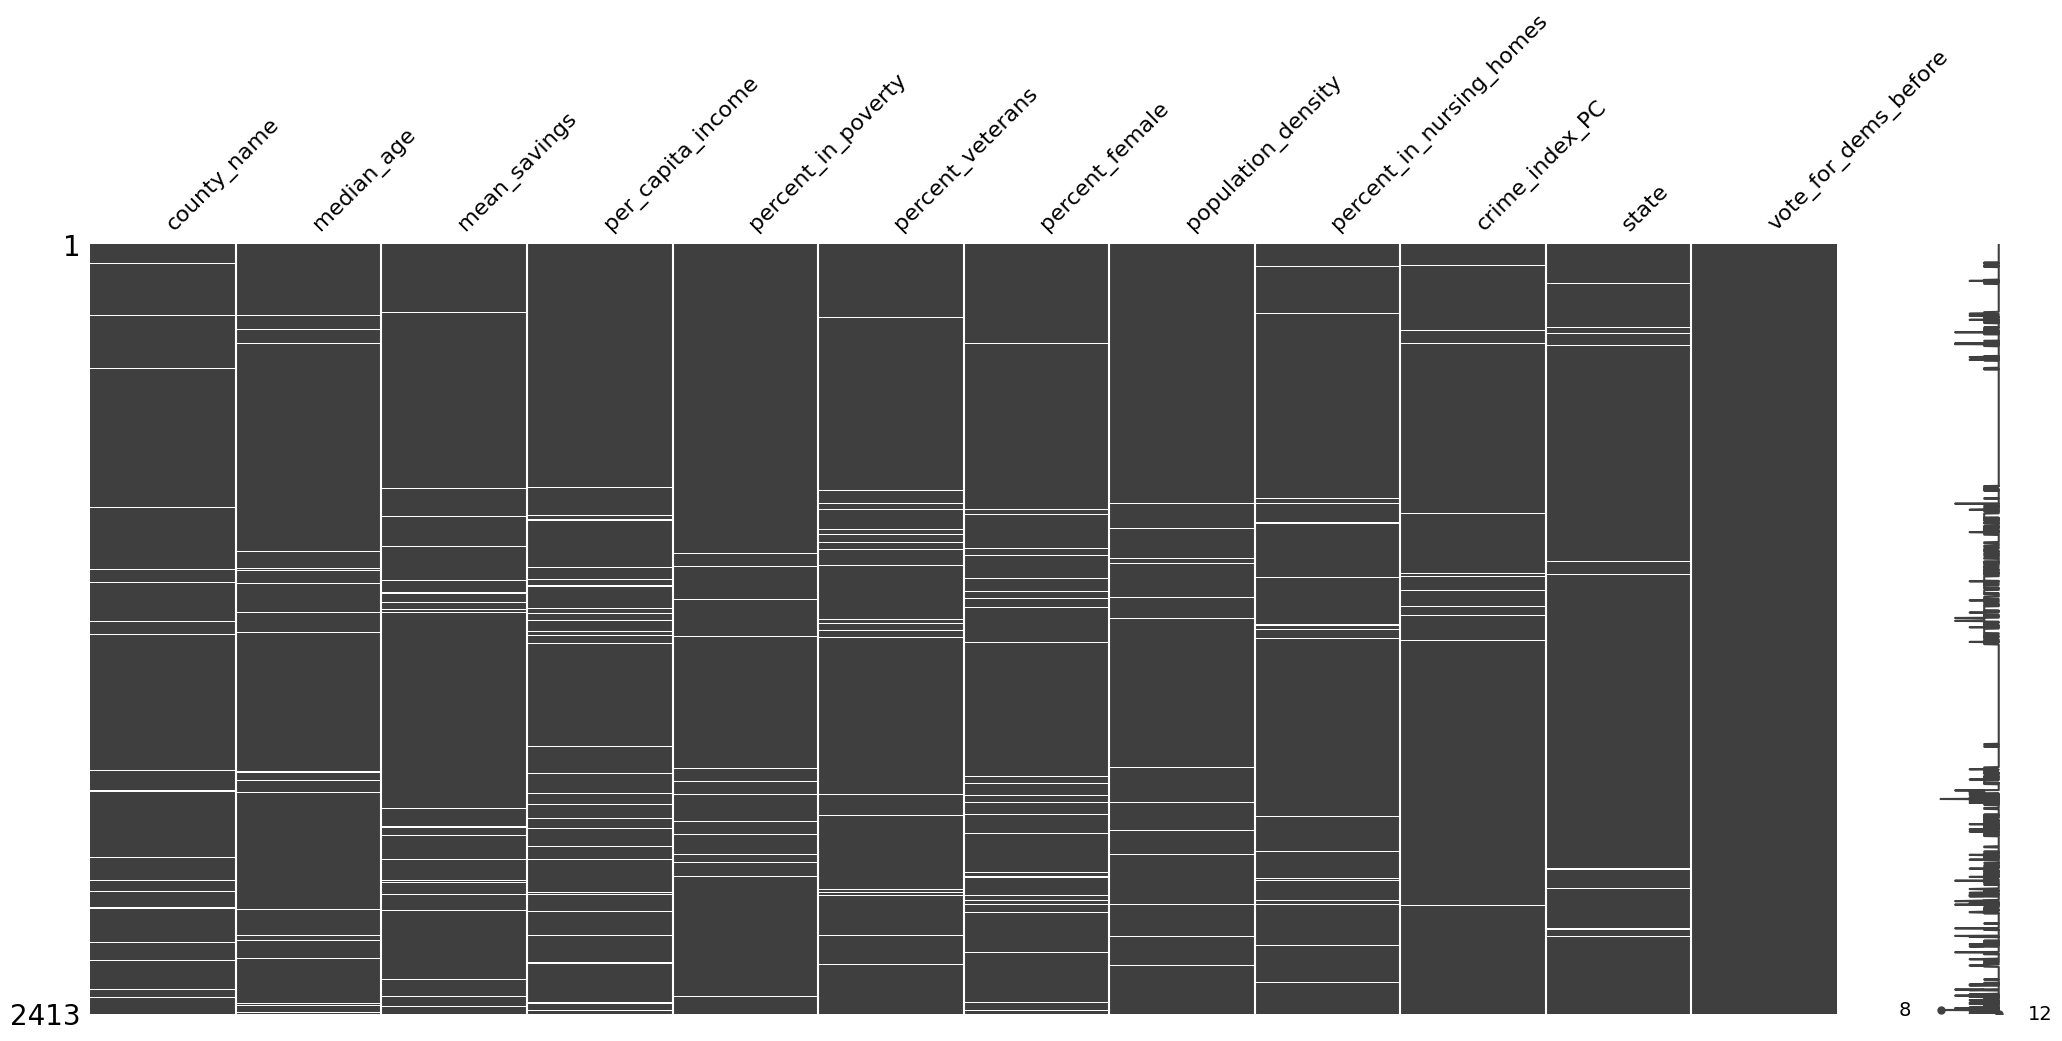

In [ ]:
msno.matrix(X)

We have some missing values in almost all the columns (except for <code>vote_for_dems_before</code>), but the percentage of missing values column by column, as can be seen from the next code cell, is very low.

In [ ]:
X.isnull().sum(axis=0)/X.shape[0]

county_name                 0.026109
median_age                  0.026937
mean_savings                0.030667
per_capita_income           0.041442
percent_in_poverty          0.019478
percent_veterans            0.026109
percent_female              0.026523
population_density          0.020721
percent_in_nursing_homes    0.026109
crime_index_PC              0.016162
state                       0.016991
vote_for_dems_before        0.000000
dtype: float64

---

# Create the pipeline

> Country_name
As we can see in the next code block, this column contains all the names of the counties. It contains almost all unique values (except for some common counties' names like Washington or Franklin) and so I decide to remove this column. Furthermore, the name of a county does not influence if that county voted for Bill Clinton or not. It is not a relevant feature for this type of prediction because it does not provide any demographic information or political preference.

In [ ]:
X["county_name"].value_counts()

Washington    27
Jefferson     23
Franklin      23
Jackson       17
Monroe        16
              ..
Barry          1
Ventura        1
Larue          1
Bennington     1
Jewell         1
Name: county_name, Length: 1424, dtype: int64

---

> Median_age                                                                                                                                                                                                                                                                                                                                                               This feature contains the median age of county residents that is expressed as a float (with one decimal). Since there are some missing values I will use the SimpleImputer with strategy mean. To scale, I will use instead the StandardScaler.

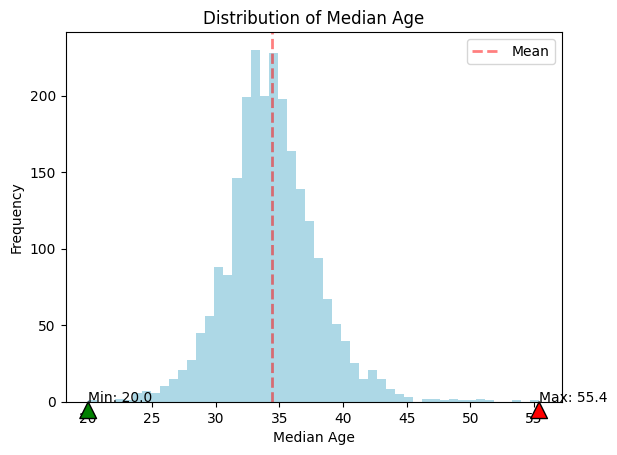

In [ ]:
# Get the values of the "mean_savings" feature
mean_savings = X["median_age"]

# Create the histogram
plt.hist(mean_savings, bins = 50, color = 'lightblue')

# Add labels to the axes
plt.xlabel("Median Age")
plt.ylabel("Frequency")

# Add a title to the plot
plt.title("Distribution of Median Age")

# Annotate the plot with the mean value
mean_value = mean_savings.mean()
plt.axvline(mean_value, color='r', linestyle='dashed', linewidth=2, label='Mean', alpha=0.5)
plt.legend()

# Annotate the plot with the min and max values
min_value = mean_savings.min()
max_value = mean_savings.max()
plt.annotate(f'Min: {min_value}', xy=(min_value, 0), xytext=(min_value, 0.2),
             arrowprops=dict(facecolor='green', shrink=0.05))
plt.annotate(f'Max: {max_value}', xy=(max_value, 0), xytext=(max_value, 0.2),
             arrowprops=dict(facecolor='red', shrink=0.05))

# Show the plot
plt.show()

In [ ]:
pipeline_median_age = Pipeline([
    ("1", SimpleImputer(strategy="mean")),
    ("2", StandardScaler())
])

---

> Mean_savings
This feature  represents the average amount of saving a county resident has.
 I decide to handle the missing values of this column with KNNImputer with strategy n_neighbors=10 and to use the StandardScaler.

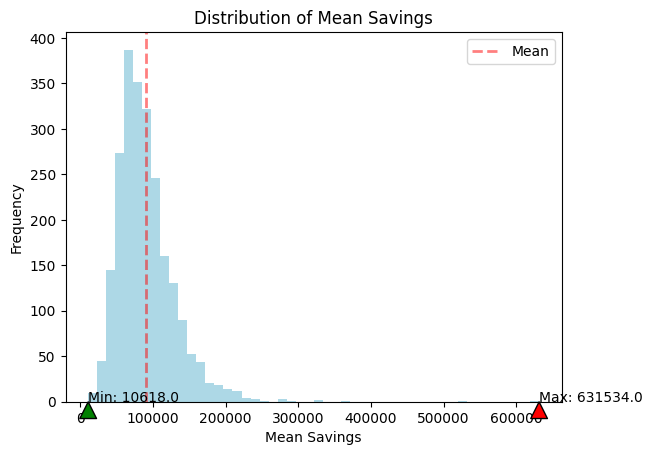

In [ ]:
# Get the values of the "mean_savings" feature
mean_savings = X["mean_savings"]

# Create the histogram
plt.hist(mean_savings, bins = 50, color = 'lightblue')

# Add labels to the axes
plt.xlabel("Mean Savings")
plt.ylabel("Frequency")

# Add a title to the plot
plt.title("Distribution of Mean Savings")

# Annotate the plot with the mean value
mean_value = mean_savings.mean()
plt.axvline(mean_value, color='r', linestyle='dashed', linewidth=2, label='Mean', alpha=0.5)
plt.legend()

# Annotate the plot with the min and max values
min_value = mean_savings.min()
max_value = mean_savings.max()
plt.annotate(f'Min: {min_value}', xy=(min_value, 0), xytext=(min_value, 0.2),
             arrowprops=dict(facecolor='green', shrink=0.05))
plt.annotate(f'Max: {max_value}', xy=(max_value, 0), xytext=(max_value, 0.2),
             arrowprops=dict(facecolor='red', shrink=0.05))

# Show the plot
plt.show()

> Keep in mind that the KNNImputer class can be slower than the SimpleImputer class, especially for large datasets. It is fundamentally important to consider the trade-off between accuracy and computational efficiency when deciding which imputation method to use.

In [ ]:
pipeline_mean_savings = Pipeline([
    ("1", KNNImputer(n_neighbors=10)),
    ("2", StandardScaler())
])

---

> Percent_in_poverty, percent_veterans, percent_female, percent_in_nursing_home
For these columns (from now on just called percent columns) I will use the KNNImputer to lead to more accurate imputations and the MinMaxScaler because those features are percentages and so by definition, they range between 0 and 100, so it is easy to reduce all to a smaller range between 0 and 1.

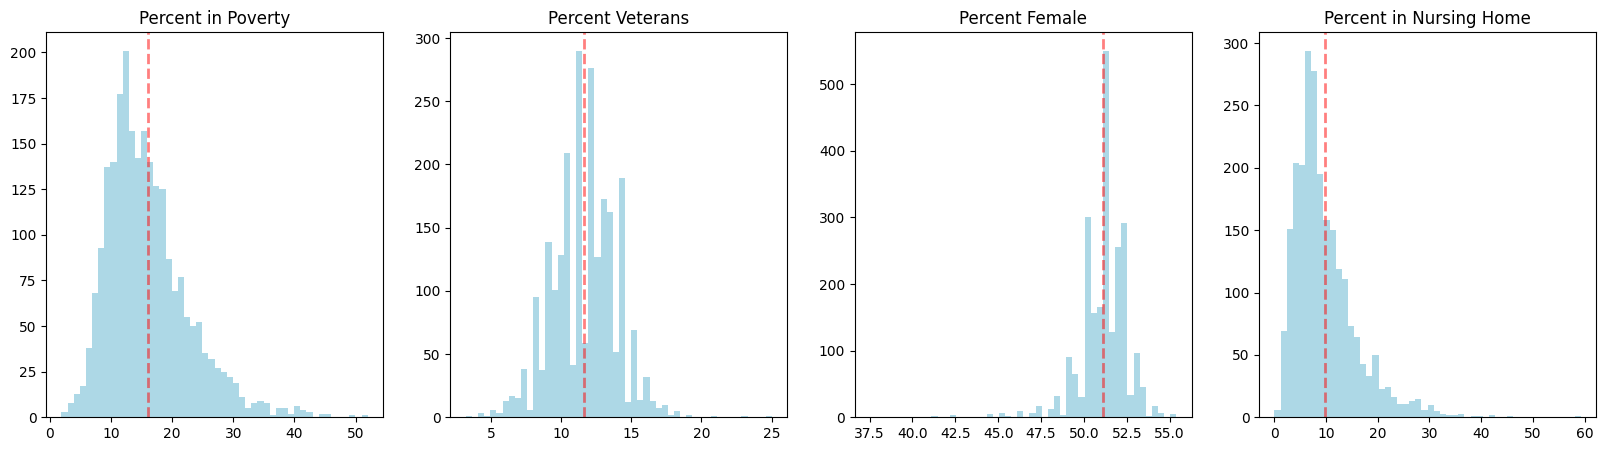

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with 4 subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Set the title for each subplot
axes[0].set_title("Percent in Poverty")
axes[1].set_title("Percent Veterans")
axes[2].set_title("Percent Female")
axes[3].set_title("Percent in Nursing Home")

# Get the values of each feature
percent_in_poverty = X["percent_in_poverty"]
percent_veterans = X["percent_veterans"]
percent_female = X["percent_female"]
percent_in_nursing_homes = X["percent_in_nursing_homes"]

# Plot the histograms for each feature
axes[0].hist(percent_in_poverty, bins = 50, color = 'lightblue')
axes[1].hist(percent_veterans, bins = 50, color = 'lightblue')
axes[2].hist(percent_female, bins = 50, color = 'lightblue')
axes[3].hist(percent_in_nursing_homes, bins = 50, color = 'lightblue')

# Annotate the plot with the mean value
mean_value_poverty = percent_in_poverty.mean()
mean_value_veterans = percent_veterans.mean()
mean_value_female = percent_female.mean()
mean_value_nursing_homes = percent_in_nursing_homes.mean()
axes[0].axvline(mean_value_poverty, color='r', linestyle='dashed', linewidth=2, label='Mean', alpha=0.5)
axes[1].axvline(mean_value_veterans, color='r', linestyle='dashed', linewidth=2, label='Mean', alpha=0.5)
axes[2].axvline(mean_value_female, color='r', linestyle='dashed', linewidth=2, label='Mean', alpha=0.5)
axes[3].axvline(mean_value_nursing_homes, color='r', linestyle='dashed', linewidth=2, label='Mean', alpha=0.5)

# Show the plot
plt.show()


In [ ]:
pipeline_percent = Pipeline([
    ("1", KNNImputer(n_neighbors=5)),
    ("2", MinMaxScaler())
])

---

> State
This feature contains the state a county is located in.
 The state is abbreviated with two letters and it contains categorical data. For the missing values, I will use SimpleImputer with strategy most_frequent. Also, I will use the OneHotEncoder since it is nominal and not ordinal.

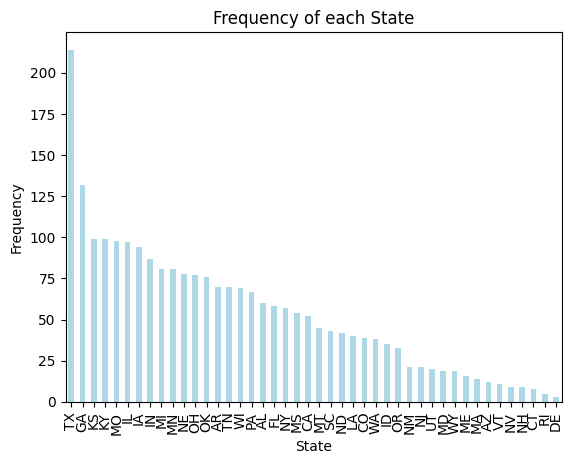

In [ ]:
import matplotlib.pyplot as plt

# Count the frequency of each state
state_counts = X["state"].value_counts()

# Create a bar plot
state_counts.plot(kind='bar', color = 'lightblue')

# Set the title and labels
plt.title("Frequency of each State")
plt.xlabel("State")
plt.ylabel("Frequency")

# Show the plot
plt.show()


In [ ]:
pipeline_state = Pipeline([
    ("1", SimpleImputer(strategy='most_frequent')),
    ("2", OneHotEncoder(categories='auto',drop='first',handle_unknown='ignore'))
])

---

> Vote_for_dems_before
This feature (added by me and not present in the original dataset on Kaggle) shows if a county voted for a democratic candidate in the past 1988 United States presidential election. It has either 0 or 1. I believe it is a nice feature to have

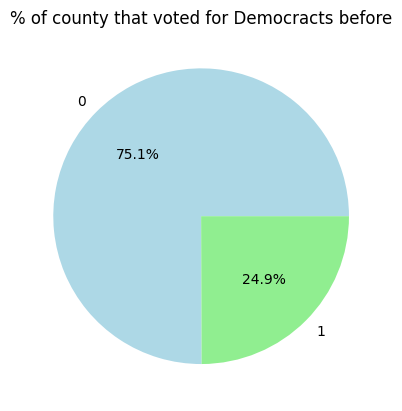

In [ ]:
# Count the frequency of each item
vote_dems_counts = X["vote_for_dems_before"].value_counts()

# Create a pie chart
vote_dems_counts.plot(kind='pie', autopct='%1.1f%%', colors = ['lightblue','lightgreen'])

# Set the title
plt.title("% of county that voted for Democracts before")

# Remove the y-axis label
plt.ylabel('')


# Show the plot
plt.show()


> With the "*1 trick" I converted True to 1 and False to 0 to handle numerical features. Since it is a Boolean column I will not use any scaler.

In [ ]:
pipeline_vote_for_dems_before = Pipeline([
    ("1", SimpleImputer(strategy='most_frequent'))
])

---

> All the other columns
For the columns per_capita_income, population_density, crime_index_PC I will use a general pipeline with KNNImputer. All the features contain missing values, so we have to apply an imputation strategy. In this case the strategy is based on the idea of
k-nearest neighbors and the StandardScaler.

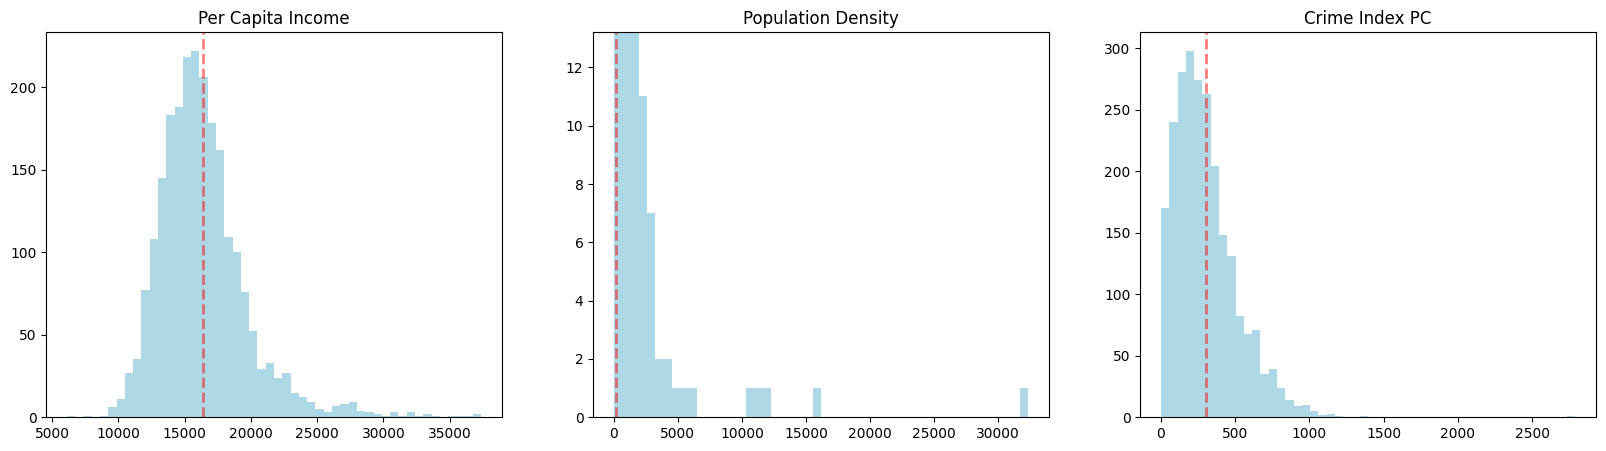

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Set the title for each subplot
axes[0].set_title("Per Capita Income")
axes[1].set_title("Population Density")
axes[2].set_title("Crime Index PC")

# Get the values of each feature
per_capita_income = X["per_capita_income"]
population_density = X["population_density"]
crime_index_PC = X["crime_index_PC"]

axes[1].set_ylim(0, population_density.value_counts().max()*1.2)

# Plot the histograms for each feature
axes[0].hist(per_capita_income, bins = 50, color = 'lightblue')
axes[1].hist(population_density, bins = 50, color = 'lightblue')
axes[2].hist(crime_index_PC, bins = 50, color = 'lightblue')

# Annotate the plot with the mean value
mean_per_capita_income = per_capita_income.mean()
mean_population_density = population_density.mean()
mean_crime_index_PC = crime_index_PC.mean()
axes[0].axvline(mean_per_capita_income, color='r', linestyle='dashed', linewidth=2, label='Mean', alpha=0.5)
axes[1].axvline(mean_population_density, color='r', linestyle='dashed', linewidth=2, label='Mean', alpha=0.5)
axes[2].axvline(mean_crime_index_PC, color='r', linestyle='dashed', linewidth=2, label='Mean', alpha=0.5)

# Show the plot
plt.show()


In [ ]:
pipeline_general = Pipeline([
    ("1", KNNImputer(n_neighbors=5)),
    ("2", StandardScaler())
])

---

## Create the column transformer

With <code>remainder="drop"</code> I discard all the others columns not inolved in the selection. In this case I remove the column *county_name*. Also <code>verbose_feature_names_out</code> is set equal to False so that the output of the transformer will not include the names of the columns that were transformed. Furthermore, since there are no columns that contains a large number of missing value or of zeros I will set the <code>sparse_threshold</code> equal to 0.

In [ ]:
final_transformation = ColumnTransformer(transformers=[
    ("1", pipeline_median_age, ["median_age"]),
    ("2", pipeline_mean_savings, ["mean_savings"]),
    ("3", pipeline_percent, ["percent_in_poverty", "percent_veterans", "percent_female", "percent_in_nursing_homes"]),
    ("4", pipeline_general, ["per_capita_income", "population_density", "crime_index_PC"]),
    ("5", pipeline_state, ["state"]),
    ("6", pipeline_vote_for_dems_before, ["vote_for_dems_before"])
],
remainder='drop',
verbose_feature_names_out=False,
sparse_threshold=0,
n_jobs = -1
)

In [ ]:
## This was a test to check if the final transformation worked as expected.
#X = pd.DataFrame(final_transformation.fit_transform(X), columns=final_transformation.get_feature_names_out())
#X

---

# Training and test sets

Now it is possible to split the entire dataset in train and test. I will use a test_size of 0.25. The <code>random_state</code> is set to be 31 (personal lucky number).

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, stratify = y, random_state=31)

In [ ]:
print('Shape of X_train: {}\nShape of X_test: {}'.format(X_train.shape, X_test.shape))

Shape of X_train: (1809, 12)
Shape of X_test: (604, 12)


---

# Model selection

We have to select the best candidates among all the candidate models. To do so we use a nested-cross validation process.

In [ ]:
y.value_counts()

0    1220
1    1193
Name: clinton_win, dtype: int64

In [ ]:
model_pipeline = IMBPipeline([
    ('trans', final_transformation),
    ("sampler", RandomOverSampler()),
    ('dim_reduction', PCA(n_components=0.8)),
    ('classifier', Perceptron())
])

In [ ]:
model_pipeline.fit(X_train,y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(n_jobs=-1, sparse_threshold=0,
                                   transformers=[('1',
                                                  Pipeline(steps=[('1',
                                                                   SimpleImputer()),
                                                                  ('2',
                                                                   StandardScaler())]),
                                                  ['median_age']),
                                                 ('2',
                                                  Pipeline(steps=[('1',
                                                                   KNNImputer(n_neighbors=10)),
                                                                  ('2',
                                                                   StandardScaler())]),
                                                  ['mean_savings']),
                                                 ('3',
                                                  Pipeline(steps=[('1',
                                                                   KNNImputer()),
                                                                  ('2',
                                                                   MinMaxScaler())]),
                                                  ['percent_in_poverty...
                                                  Pipeline(steps=[('1',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('2',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['state']),
                                                 ('6',
                                                  Pipeline(steps=[('1',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['vote_for_dems_before'])],
                                   verbose_feature_names_out=False)),
                ('sampler', RandomOverSampler()),
                ('dim_reduction', PCA(n_components=0.8)),
                ('classifier', Perceptron())])

In [ ]:
model_pipeline.predict(X_test)

array([1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,

The list <code>sampler_configs</code> contains three different dictionaries for over-sampling methods and their respective hyperparameters.
- The first dictionary contains no over-sampling method, so no over-sampling will be performed.
- The second dictionary uses the SMOTE strategy with different hyperparameters that can be choose. <code>(n_jobs=-1)</code> means that all CPU will be used.
- The last dictionary uses the RandomverSampler strategy with his hyperparameters. As an example, *0.9* is that the ratio of the minority class over the number of samples in the majority class after resampling.

In [ ]:
sampler_configs = [
    {
        'sampler':[None],
    },
    {
        'sampler':[SMOTE(n_jobs=-1)],
        'sampler__sampling_strategy':[0.9, 0.8, 0.7]
    },
    {
        'sampler':[RandomOverSampler()],
        'sampler__sampling_strategy':[0.9, 0.8, 0.7]
    }
]

The list <code>dim_reduction_configs</code> contains a list of different dimensionality reduction strategies that can be applied.
- The first strategy uses PCA and can choose between different numbers of components to keep in the transformed dataset.
- The second strategy for dimensionality reduction is LDA and display the features of a dataset in a lower-dimensional space.
- The last strategy is SFS and contains different hyparamenters from which to choose.

In [ ]:
dim_reduction_configs = [
    {
        'dim_reduction': [PCA()] ,
        'dim_reduction__n_components': [0.5, 0.6, 0.7, 0.8, 0.9]
    },
    {
        'dim_reduction': [LDA()]
    },
    {
        'dim_reduction': [SFS(estimator=Perceptron(), cv = None, scoring="f1")],
        'dim_reduction__estimator': [Perceptron(), LogisticRegression()],
        'dim_reduction__k_features' : [5,7,10]
    }
]

The list <code>classifier_configs</code> define a set of configurations for different classifiers.
- **Perceptron** has as parameters the learning rate and the weight is use when fitting the model. The class_weight hyperparameter can be set to None or to "balanced", which means that the class weights will be either to 1 for all the classes or set to the inverse proportional to the class frequencies in the input data.
- **LogisticRegression**. The solver (lib_linear) is the algorithm to use in the optimization problem. I decided to use lib_libear because is more efficienty for small datasets.
- **KNeighborsClassifier**. I choosed to specify only the number of neighbors to use. To avoid tie in the k-nearest neighbors vote I used only odd numbers.
- **RandomForestClassifier**. n_estimators specifies the number of three in the forest, max_depth specifies the maximum depth of the tree.

In [ ]:
classifier_configs = [
    {
        'classifier__eta0' : loguniform(0.001, 1),
        'classifier': [Perceptron()],
        'classifier__class_weight' : [None, "balanced"]

    },
    {
        'classifier': [LogisticRegression(solver="lib_linear")],
        'classifier__C' : loguniform(0.001, 1),
        'classifier__penalty': ["l1", "l2"],
        'classifier__class_weight' : [None, "balanced"]

    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3,5,7,9,11]
    },
    {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [10, 50, 100,150, 200],
        'classifier__max_depth': [None, 2, 5, 10, 20],
        'classifier__class_weight': [None, 'balanced']
    }
]

The result of this code is a list of dictionaries, where each dictionary contains a complete configuration for a model that consists of a sampler, a dimensionality reduction method, and a classifier.

In [ ]:
all_configs = [dict(itertools.chain(*(e.items() for e in configuration)))
for configuration in itertools.product(sampler_configs,dim_reduction_configs,classifier_configs)]

In [ ]:
f'Number of all possible configurations: {len(all_configs)}'

'Number of all possible configurations: 36'

<code>RandomizedSearchCV</code> performs randomized search for hyperparameter optimization. It works by sampling a set of hyperparameter configurations from a distribution and evaluating them using cross-validation. It contains as hyperparameters
- model_pipeline: the model that will be used for the search.
- param_distribution: distribution from which the hyperparameter configurations will be sampled. It contains a dictionary with parameters to try
- n_iter: number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution
- c_jobs: all available CPUs will be used.
- cv: number of cross validations folds that will be used.
- scoring: metric used to evaluate the model performance.
- verbose: give additional information about the progress to understand how the search is progressing.

In [ ]:
rs = RandomizedSearchCV(
    model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs) * 5,
    n_jobs=-1,
    cv = 5,
    scoring='f1',
    verbose = 1
)

In [ ]:
scores = cross_validate(rs, X_train, y_train, scoring='f1', cv = 5, return_estimator=True, verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Fitting 5 folds for each of 180 candidates, totalling 900 fits
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/extmath.py:1017: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/extmath.py:1017: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
[CV] END ......................................., score=0.764 total time=  32.0s
Fitting 5 folds for each of 180 candidates, totalling 900 fits
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.0s remaining:    0.0s
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/extmath.py:1017: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/uti

In [ ]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)
    print(" ")

None
LinearDiscriminantAnalysis()
KNeighborsClassifier(n_neighbors=11) {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 11, 'p': 2, 'weights': 'uniform'}
0.7638483965014577
----------
 
None
LinearDiscriminantAnalysis()
KNeighborsClassifier(n_neighbors=11) {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 11, 'p': 2, 'weights': 'uniform'}
0.7977207977207977
----------
 
None
LinearDiscriminantAnalysis()
RandomForestClassifier(max_depth=5, n_estimators=50) {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0.7207207207207207

In [ ]:
for estimator in scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    print(f'F1 on training set: {f1_train}, F1 on test set: {f1_test}, Difference of F1 on train and test set: {f1_train - f1_test}')

F1 on training set: 0.8051948051948051, F1 on test set: 0.7577854671280276, Difference of F1 on train and test set: 0.047409338066777496
F1 on training set: 0.8051948051948051, F1 on test set: 0.7577854671280276, Difference of F1 on train and test set: 0.047409338066777496
F1 on training set: 0.8165612420931571, F1 on test set: 0.7755102040816326, Difference of F1 on train and test set: 0.04105103801152443
F1 on training set: 0.7746305418719213, F1 on test set: 0.779783393501805, Difference of F1 on train and test set: -0.00515285162988377
F1 on training set: 0.8051948051948051, F1 on test set: 0.7577854671280276, Difference of F1 on train and test set: 0.047409338066777496


It can be seen that all the models have a generalization gap that is not too large, all the F1 training seems to be around 0.80. After testing different model I decide to use <code>LinearDiscriminantAnalysis()</code> with <code>KNeighborsClassifier(n_neighbors=11)</code>. This is because it reduce the difference of the F1 on train and on test to be even less then 0.05. Even if f1_score would result higher with other models, such as RandomForestClassifier, with <code>KNeighborsClassifier(n_neighbors=11)</code> the validation and training accuracy are closer to eachother and almost constant around 0.8 when the training size increases.

----

# Refinement of the selected model


In [ ]:
best_model_pipeline = IMBPipeline([
    ('trans', final_transformation),

    # For LogisticRegression
    #('classifier',LogisticRegression(solver='saga', penalty = 'l2'))

    # For KNeighborsClassifier
    ("dim_reduction", LDA()),
    ("classifier", KNeighborsClassifier(n_neighbors=11))

    # For RandomForestClassifier
    #("dim_reduction", LDA()),
    #("classifier", RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=10))
])

In [ ]:
params = {
    # For LogisticRegression
    #"classifier__C": uniform(loc = 15, scale = 60)  # added 0 and 0

    # For KNeighborsClassifier
    "classifier__n_neighbors": [3,5,7,9,11,13,15]

    # For RandomForestClassifier
    #"classifier__n_estimators": [10, 50, 150, 200],
    #"classifier__max_depth": [None, 2, 5, 10],
    #"classifier__class_weight": [None, 'balanced']
}

In [ ]:
rs_best = RandomizedSearchCV(
    estimator = best_model_pipeline,
    param_distributions = params,
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3),
    n_iter=20,
    scoring='f1'
)

In [ ]:
rs_best.fit(X_train, y_train)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=None),
                   estimator=Pipeline(steps=[('trans',
                                              ColumnTransformer(n_jobs=-1,
                                                                sparse_threshold=0,
                                                                transformers=[('1',
                                                                               Pipeline(steps=[('1',
                                                                                                SimpleImputer()),
                                                                                               ('2',
                                                                                                StandardScaler())]),
                                                                               ['median_age']),
                                                                              ('2',
                                                                               Pipeline(steps=[('1',
                                                                                                KNNImputer(n_neighbors=10)),
                                                                                               ('2',
                                                                                                StandardScaler())]),
                                                                               ['...
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['state']),
                                                                              ('6',
                                                                               Pipeline(steps=[('1',
                                                                                                SimpleImputer(strategy='most_frequent'))]),
                                                                               ['vote_for_dems_before'])],
                                                                verbose_feature_names_out=False)),
                                             ('dim_reduction',
                                              LinearDiscriminantAnalysis()),
                                             ('classifier',
                                              KNeighborsClassifier(n_neighbors=11))]),
                   n_iter=20,
                   param_distributions={'classifier__n_neighbors': [3, 5, 7, 9,
                                                                    11, 13,
                                                                    15]},
                   scoring='f1')

In [ ]:
rs_best.best_estimator_

Pipeline(steps=[('trans',
                 ColumnTransformer(n_jobs=-1, sparse_threshold=0,
                                   transformers=[('1',
                                                  Pipeline(steps=[('1',
                                                                   SimpleImputer()),
                                                                  ('2',
                                                                   StandardScaler())]),
                                                  ['median_age']),
                                                 ('2',
                                                  Pipeline(steps=[('1',
                                                                   KNNImputer(n_neighbors=10)),
                                                                  ('2',
                                                                   StandardScaler())]),
                                                  ['mean_savings']),
                                                 ('3',
                                                  Pipeline(steps=[('1',
                                                                   KNNImputer()),
                                                                  ('2',
                                                                   MinMaxScaler())]),
                                                  ['percent_in_poverty...
                                                  Pipeline(steps=[('1',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('2',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['state']),
                                                 ('6',
                                                  Pipeline(steps=[('1',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['vote_for_dems_before'])],
                                   verbose_feature_names_out=False)),
                ('dim_reduction', LinearDiscriminantAnalysis()),
                ('classifier', KNeighborsClassifier(n_neighbors=15))])

In [ ]:
f1_score(y_test, rs_best.best_estimator_.predict(X_test))  #0.77 with second one

0.7622377622377623

I want to focus on the <code>f1_score</code> that ranges usually between 0.74 and 0.78. This algorithm is able to predict with an f1_score around 0.76 if a county voted in the 1992 election for Clinton (member of the Democratic party) or not. I want to acknowledge the fact that the result is based on some objective data (like the mean age, population density, and percent of people in nursing homes) while there are some fundamental and more personal features that are not present in the dataset.


As an example, the dataset is not taking into account the different ethnicities, religions, and personal backgrounds of the voters, which can have a significant impact on voting behavior.
- **Ethnicity** can particularly influence the voting behavior of some ethnic groups. For example, African Americans and Hispanic Americans are more likely to vote for Democratic candidates for different reasons (including experiences with discrimination and economic disparities).
- Regarding **religion** we can imagine that a voter's religious beliefs will influence their political behavior. As an example, somebody who is religious might vote for a republican candidate because is aligns with the party's stance on issues such as abortion, legalization, and same-sex marriage.
- **Personal background**, on the other hand, it include educational level and daily experiences. This is particularly personal because it contains also the environment close to a person and how the environment is actually perceived by the individual.

Those are just some examples of why I believe that predicting if a county voted for democrats or not based on those features will almost never be perfect. We have to acknowledge that people, even if they can be clustered into different groups, based for example on income or gender, there are some personal factors and beliefs that will influence nevertheless if they will vote for democrats or not.

In [ ]:
cls = rs_best.best_estimator_

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(cls,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                       cv = 5,
                                                       n_jobs = -1,
                                                       scoring = 'f1',
                                                       shuffle = False)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sk

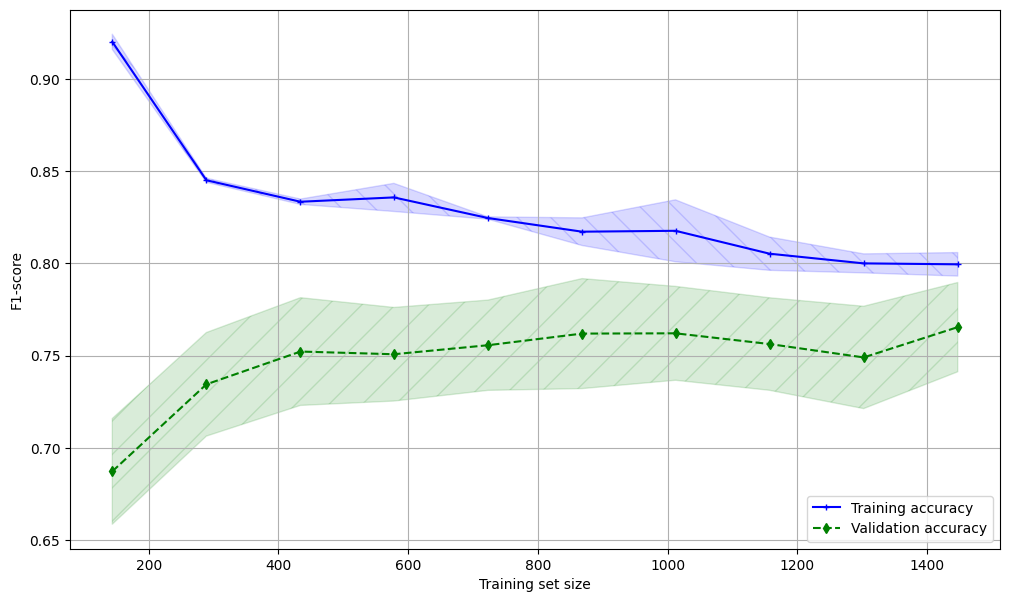

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
axA = fig.add_subplot()

axA.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

axA.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15,
                 color='blue',
                 hatch='\\')

axA.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

axA.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15,
                 color='green',
                 hatch = "/")

axA.grid()
axA.set_xlabel('Training set size')
axA.set_ylabel('F1-score')
axA.legend(loc='lower right')
axA.set_autoscale_on(True)

In [ ]:
range_classifier = [3,5,7,9,11,13,15]
train_scores, test_scores = validation_curve(cls,
        X=X_train,
        y=y_train,
        param_range=
        range_classifier,
        param_name='classifier__n_neighbors',
        cv=5,
        n_jobs=-1,
        scoring='f1'
)

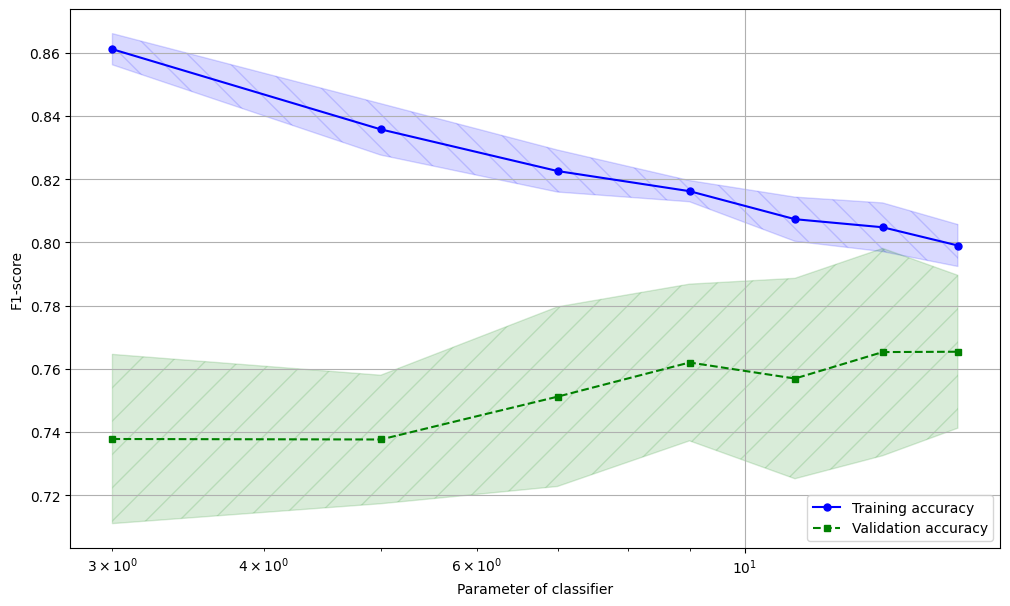

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
axB = fig.add_subplot()
axB.plot(range_classifier, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

axB.fill_between(range_classifier,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15,
                 color='blue',
                 hatch='\\')

axB.plot(range_classifier, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

axB.fill_between(range_classifier,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15,
                 color='green',
                 hatch = "/")

axB.grid()
axB.set_xlabel('Parameter of classifier')
axB.set_ylabel('F1-score')
axB.legend(loc='lower right')
axB.set_xscale('log')
axB.set_autoscale_on(True)